# COSMOS master catalogue

This notebook presents the merge of the various pristine catalogues to produce HELP mater catalogue on COSMOS.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
33f5ec7 (Wed Dec 6 16:56:17 2017 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np
from pymoc import MOC

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [4]:
candels = Table.read("{}/CANDELS.fits".format(TMP_DIR))
cfhtls = Table.read("{}/CFHTLS.fits".format(TMP_DIR))
decals = Table.read("{}/DECaLS.fits".format(TMP_DIR))
hsc_deep = Table.read("{}/HSC-DEEP.fits".format(TMP_DIR))
hsc_udeep = Table.read("{}/HSC-UDEEP.fits".format(TMP_DIR))
kids = Table.read("{}/KIDS.fits".format(TMP_DIR))
ps1 = Table.read("{}/PS1.fits".format(TMP_DIR))
las = Table.read("{}/UKIDSS-LAS.fits".format(TMP_DIR))
wirds = Table.read("{}/CFHT-WIRDS.fits".format(TMP_DIR))


## II - Merging tables

We first merge the optical catalogues and then add the infrared ones: CANDELS, CFHTLS, DECaLS, HSC, KIDS, PanSTARRS, UKIDSS-LAS, and CFHT-WIRDS.

At every step, we look at the distribution of the distances to the nearest source in the merged catalogue to determine the best crossmatching radius.

### PanSTARRS

In [5]:
master_catalogue = ps1
master_catalogue['ps1_ra'].name = 'ra'
master_catalogue['ps1_dec'].name = 'dec'

### Add CANDELS

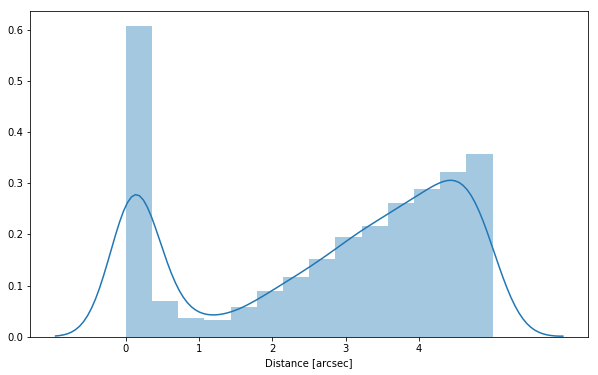

In [6]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(candels['candels_ra'], candels['candels_dec'])
)

In [7]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, candels, "candels_ra", "candels_dec", radius=0.8*u.arcsec)

### Add CFHTLS

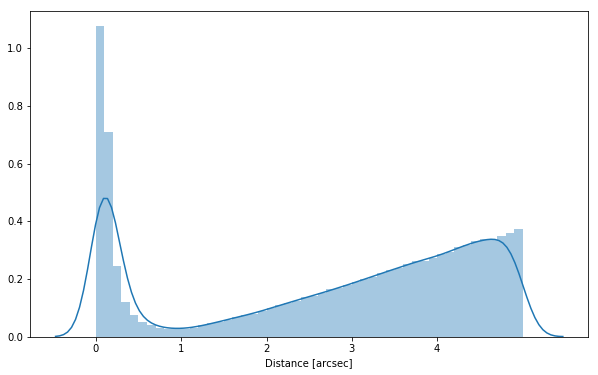

In [8]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(cfhtls['cfhtls_ra'], cfhtls['cfhtls_dec'])
)

In [9]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, cfhtls, "cfhtls_ra", "cfhtls_dec", radius=0.8*u.arcsec)

### Add DECaLS

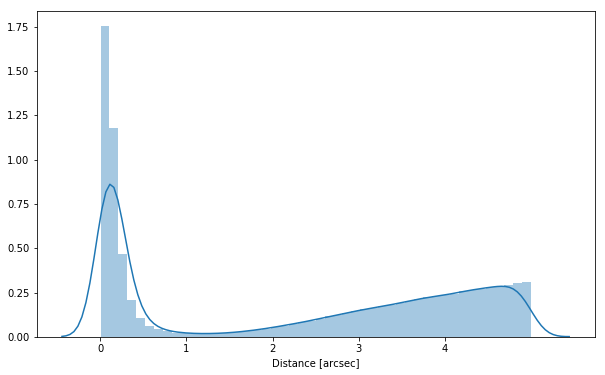

In [10]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(decals['decals_ra'], decals['decals_dec'])
)

In [11]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, decals, "decals_ra", "decals_dec", radius=0.8*u.arcsec)

### Add HSC-UDEEP

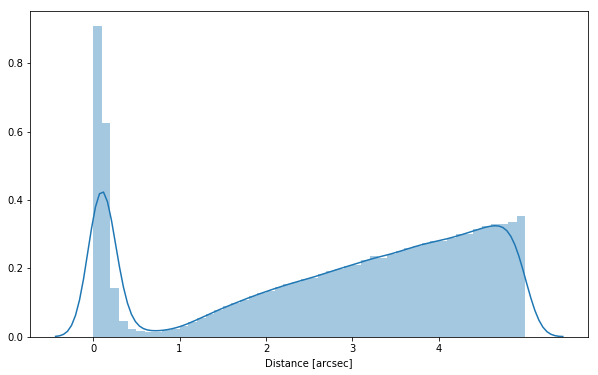

In [12]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(hsc_udeep['hsc-udeep_ra'], hsc_udeep['hsc-udeep_dec'])
)

In [13]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, hsc_udeep, "hsc-udeep_ra", "hsc-udeep_dec", radius=0.8*u.arcsec)

### Add HSC-DEEP

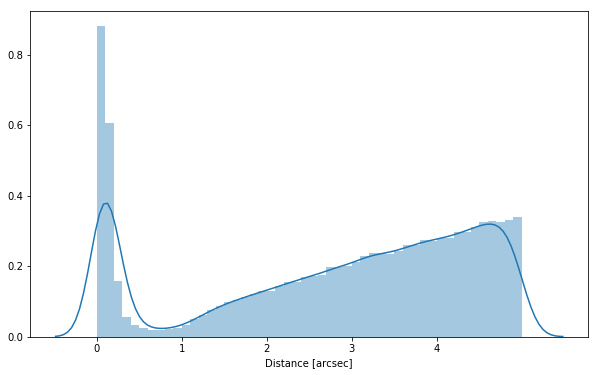

In [14]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(hsc_deep['hsc-deep_ra'], hsc_deep['hsc-deep_dec'])
)

In [15]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, hsc_deep, "hsc-deep_ra", "hsc-deep_dec", radius=0.8*u.arcsec)

### Add KIDS

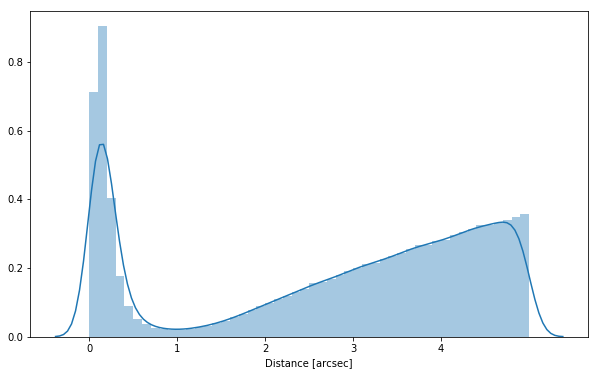

In [16]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(kids['kids_ra'], kids['kids_dec'])
)

In [17]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, kids, "kids_ra", "kids_dec", radius=0.8*u.arcsec)

### Add UKIDSS LAS

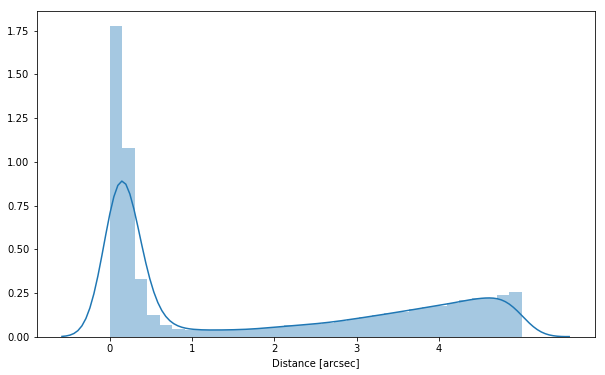

In [18]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(las['las_ra'], las['las_dec'])
)

In [19]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, las, "las_ra", "las_dec", radius=0.8*u.arcsec)

### Add CFHT-WIRDS

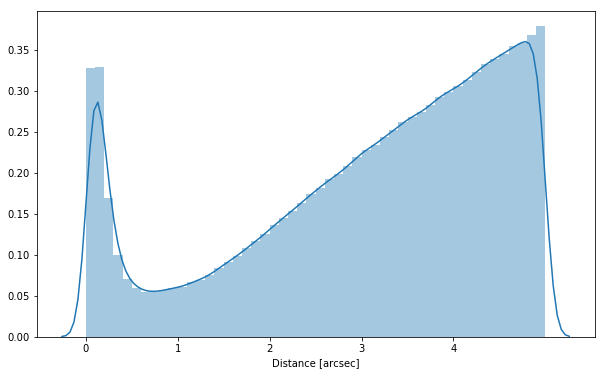

In [20]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(wirds['wirds_ra'], wirds['wirds_dec'])
)

In [22]:
#Given the graph above, we use 1 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, wirds, "wirds_ra", "wirds_dec", radius=1.*u.arcsec)

### Cleaning

When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes only from a catalogue and has no counterparts in the other, the columns from the latest are masked for that row). We indicate to use NaN for masked values for floats columns, False for flag columns and -1 for ID columns.

In [24]:
for col in master_catalogue.colnames:
    print(col)
    if "m_" in col or "merr_" in col or "f_" in col or "ferr_" in col or "stellarity" in col:
        master_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        master_catalogue[col].fill_value = 0
    elif "id" in col:
        master_catalogue[col].fill_value = -1
        
master_catalogue = master_catalogue.filled()

ps1_id
ra
dec
m_ap_gpc1_g
merr_ap_gpc1_g
m_gpc1_g
merr_gpc1_g
m_ap_gpc1_r
merr_ap_gpc1_r
m_gpc1_r
merr_gpc1_r
m_ap_gpc1_i
merr_ap_gpc1_i
m_gpc1_i
merr_gpc1_i
m_ap_gpc1_z
merr_ap_gpc1_z
m_gpc1_z
merr_gpc1_z
m_ap_gpc1_y
merr_ap_gpc1_y
m_gpc1_y
merr_gpc1_y
f_ap_gpc1_g
ferr_ap_gpc1_g
f_gpc1_g
ferr_gpc1_g
flag_gpc1_g
f_ap_gpc1_r
ferr_ap_gpc1_r
f_gpc1_r
ferr_gpc1_r
flag_gpc1_r
f_ap_gpc1_i
ferr_ap_gpc1_i
f_gpc1_i
ferr_gpc1_i
flag_gpc1_i
f_ap_gpc1_z
ferr_ap_gpc1_z
f_gpc1_z
ferr_gpc1_z
flag_gpc1_z
f_ap_gpc1_y
ferr_ap_gpc1_y
f_gpc1_y
ferr_gpc1_y
flag_gpc1_y
ps1_flag_cleaned
ps1_flag_gaia
flag_merged
candels_id
candels_stellarity


ValueError: cannot convert float NaN to integer

In [ ]:
master_catalogue[:10].show_in_notebook()

## III - Merging flags and stellarity

Each pristine catalogue contains a flag indicating if the source was associated to a another nearby source that was removed during the cleaning process.  We merge these flags in a single one.

In [ ]:
flag_cleaned_columns = [column for column in master_catalogue.colnames
                        if 'flag_cleaned' in column]

flag_column = np.zeros(len(master_catalogue), dtype=bool)
for column in flag_cleaned_columns:
    flag_column |= master_catalogue[column]
    
master_catalogue.add_column(Column(data=flag_column, name="flag_cleaned"))
master_catalogue.remove_columns(flag_cleaned_columns)

Each pristine catalogue contains a flag indicating the probability of a source being a Gaia object (0: not a Gaia object, 1: possibly, 2: probably, 3: definitely).  We merge these flags taking the highest value.

In [ ]:
flag_gaia_columns = [column for column in master_catalogue.colnames
                     if 'flag_gaia' in column]

master_catalogue.add_column(Column(
    data=np.max([master_catalogue[column] for column in flag_gaia_columns], axis=0),
    name="flag_gaia"
))
master_catalogue.remove_columns(flag_gaia_columns)

Each prisitine catalogue may contain one or several stellarity columns indicating the probability (0 to 1) of each source being a star.  We merge these columns taking the highest value.

In [ ]:
stellarity_columns = [column for column in master_catalogue.colnames
                      if 'stellarity' in column]

master_catalogue.add_column(Column(
    data=np.nanmax([master_catalogue[column] for column in stellarity_columns], axis=0),
    name="stellarity"
))
master_catalogue.remove_columns(stellarity_columns)

## IV - Adding E(B-V) column

In [ ]:
master_catalogue.add_column(
    ebv(master_catalogue['ra'], master_catalogue['dec'])
)

## V - Adding HELP unique identifiers and field columns

In [ ]:
master_catalogue.add_column(Column(gen_help_id(master_catalogue['ra'], master_catalogue['dec']),
                                   name="help_id"))
master_catalogue.add_column(Column(np.full(len(master_catalogue), "COSMOS", dtype='<U18'),
                                   name="field"))

In [ ]:
# Check that the HELP Ids are unique
if len(master_catalogue) != len(np.unique(master_catalogue['help_id'])):
    print("The HELP IDs are not unique!!!")
else:
    print("OK!")

## VI - Choosing between multiple values for the same filter

There are currently no overlapping surveys here.

In [ ]:
suprime_origin = Table()
suprime_origin.add_column(master_catalogue['help_id'])

In [ ]:
suprime_stats = Table()
suprime_stats.add_column(Column(data=['g','r','i','z','y', 'n921'], name="Band"))
for col in ["HSC-UDEEP",  "HSC-DEEP"]:
    suprime_stats.add_column(Column(data=np.full(5, 0), name="{}".format(col)))
    suprime_stats.add_column(Column(data=np.full(5, 0), name="use {}".format(col)))
    suprime_stats.add_column(Column(data=np.full(5, 0), name="{} ap".format(col)))
    suprime_stats.add_column(Column(data=np.full(5, 0), name="use {} ap".format(col)))
    

In [ ]:
uprime_bands = ['g','r','i','z','y', 'n921'] 
for band in suprime_bands:

    # Suprime total flux 
    has_hsc_udeep = ~np.isnan(master_catalogue['f_hsc-udeep_' + band])
    has_hsc_deep  = ~np.isnan(master_catalogue['f_hsc-deep_' + band])
    

    use_hsc_udeep = has_hsc_udeep
    use_hsc_deep = has_hsc_deep & ~has_hsc_udeep
 
    f_suprime = np.full(len(master_catalogue), np.nan)
    f_suprime[use_hsc_udeep] = master_catalogue['f_hsc-udeep_' + band][use_hsc_udeep]
    f_suprime[use_hsc_deep] = master_catalogue['f_hsc-deep_' + band][use_hsc_deep]
 

    ferr_suprime = np.full(len(master_catalogue), np.nan)
    ferr_suprime[use_hsc_udeep] = master_catalogue['ferr_hsc-udeep_' + band][use_hsc_udeep]
    ferr_suprime[use_hsc_deep] = master_catalogue['ferr_hsc-deep_' + band][use_hsc_deep]

    
    m_suprime = np.full(len(master_catalogue), np.nan)
    m_suprime[use_hsc_udeep] = master_catalogue['m_hsc-udeep_' + band][use_hsc_udeep]
    m_suprime[use_hsc_deep] = master_catalogue['m_hsc-deep_' + band][use_hsc_deep]


    merr_suprime = np.full(len(master_catalogue), np.nan)
    merr_suprime[use_hsc_udeep] = master_catalogue['merr_hsc-udeep_' + band][use_hsc_udeep]
    merr_suprime[use_hsc_deep] = master_catalogue['merr_hsc-deep_' + band][use_hsc_deep]


    flag_suprime = np.full(len(master_catalogue), False, dtype=bool)
    flag_suprime[use_hsc_udeep] = master_catalogue['flag_hsc-udeep_' + band][use_hsc_udeep]
    flag_suprime[use_hsc_deep] = master_catalogue['flag_hsc-deep_' + band][use_hsc_deep]


    master_catalogue.add_column(Column(data=f_suprime, name="f_suprime_" + band))
    master_catalogue.add_column(Column(data=ferr_suprime, name="ferr_suprime_" + band))
    master_catalogue.add_column(Column(data=m_suprime, name="m_suprime_" + band))
    master_catalogue.add_column(Column(data=merr_suprime, name="merr_suprime_" + band))
    master_catalogue.add_column(Column(data=flag_suprime, name="flag_suprime_" + band))

    old_hsc_udeep_columns = ['f_hsc-udeep_' + band,
                               'ferr_hsc-udeep_' + band,
                               'm_hsc-udeep_' + band, 
                               'merr_hsc-udeep_' + band,
                               'flag_hsc-udeep_' + band]
    old_hsc_deep_columns = ['f_hsc-deep_' + band,
                               'ferr_hsc-deep_' + band,
                               'm_hsc-deep_' + band, 
                               'merr_hsc-deep_' + band,
                               'flag_hsc-deep_' + band]

    
    old_columns = old_hsc_udeep_columns + old_hsc_deep_columns
    master_catalogue.remove_columns(old_columns)

    origin = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin[use_hsc_udeep] = "HSC-UDEEP"
    origin[use_hsc_deep] = "HSC-DEEP"
 
    
    suprime_origin.add_column(Column(data=origin, name= 'f_suprime_' + band ))
    
  
    # Suprime aperture flux 
    has_ap_hsc_udeep = ~np.isnan(master_catalogue['f_ap_hsc-udeep_' + band])
    has_ap_hsc_deep  = ~np.isnan(master_catalogue['f_ap_hsc-deep_' + band])
 
    

    use_ap_hsc_udeep = has_ap_hsc_udeep
    use_ap_hsc_deep = has_ap_hsc_deep & ~has_ap_hsc_udeep
  

    f_ap_suprime = np.full(len(master_catalogue), np.nan)
    f_ap_suprime[use_ap_hsc_udeep] = master_catalogue['f_ap_hsc-udeep_' + band][use_ap_hsc_udeep]
    f_ap_suprime[use_ap_hsc_deep] = master_catalogue['f_ap_hsc-deep_' + band][use_ap_hsc_deep]


    ferr_ap_suprime = np.full(len(master_catalogue), np.nan)
    ferr_ap_suprime[use_ap_hsc_udeep] = master_catalogue['ferr_ap_hsc-udeep_' + band][use_ap_hsc_udeep]
    ferr_ap_suprime[use_ap_hsc_deep] = master_catalogue['ferr_ap_hsc-deep_' + band][use_ap_hsc_deep]
   
    
    m_ap_suprime = np.full(len(master_catalogue), np.nan)
    m_ap_suprime[use_ap_hsc_udeep] = master_catalogue['m_ap_hsc-udeep_' + band][use_ap_hsc_udeep]
    m_ap_suprime[use_ap_hsc_deep] = master_catalogue['m_ap_hsc-deep_' + band][use_ap_hsc_deep]
  

    merr_ap_suprime = np.full(len(master_catalogue), np.nan)
    merr_ap_suprime[use_ap_hsc_udeep] = master_catalogue['merr_ap_hsc-udeep_' + band][use_ap_hsc_udeep]
    merr_ap_suprime[use_ap_hsc_deep] = master_catalogue['merr_ap_hsc-deep_' + band][use_ap_hsc_deep]
  


    master_catalogue.add_column(Column(data=f_ap_suprime, name="f_ap_suprime_" + band))
    master_catalogue.add_column(Column(data=ferr_ap_suprime, name="ferr_ap_suprime_" + band))
    master_catalogue.add_column(Column(data=m_ap_suprime, name="m_ap_suprime_" + band))
    master_catalogue.add_column(Column(data=merr_ap_suprime, name="merr_ap_suprime_" + band))


    old_ap_hsc_udeep_columns = ['f_ap_hsc-udeep_' + band,
                               'ferr_ap_hsc-udeep_' + band,
                               'm_ap_hsc-udeep_' + band, 
                               'merr_ap_hsc-udeep_' + band]
    old_ap_hsc_deep_columns = ['f_ap_hsc-deep_' + band,
                               'ferr_ap_hsc-deep_' + band,
                               'm_ap_hsc-deep_' + band, 
                               'merr_ap_hsc-deep_' + band]

    
    old_ap_columns = old_ap_hsc_udeep_columns + old_ap_hsc_deep_columns + old_ap_hsc_wide_columns
    master_catalogue.remove_columns(old_ap_columns)

    origin_ap = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin_ap[use_ap_hsc_udeep] = "HSC-UDEEP"
    origin_ap[use_ap_hsc_deep] = "HSC-DEEP"

    
    suprime_origin.add_column(Column(data=origin_ap, name= 'f_ap_suprime_' + band ))

   
    suprime_stats['HSC-UDEEP'][suprime_stats['Band'] == band] = np.sum(has_hsc_udeep)
    suprime_stats['HSC-DEEP'][suprime_stats['Band'] == band] = np.sum(has_hsc_deep)

    suprime_stats['use HSC-UDEEP'][suprime_stats['Band'] == band] = np.sum(use_hsc_udeep)
    suprime_stats['use HSC-DEEP'][suprime_stats['Band'] == band] = np.sum(use_hsc_deep)

    suprime_stats['HSC-UDEEP ap'][suprime_stats['Band'] == band] = np.sum(has_ap_hsc_udeep)
    suprime_stats['HSC-DEEP ap'][suprime_stats['Band'] == band] = np.sum(has_ap_hsc_deep)

    suprime_stats['use HSC-UDEEP ap'][suprime_stats['Band'] == band] = np.sum(use_ap_hsc_udeep)
    suprime_stats['use HSC-DEEP ap'][suprime_stats['Band'] == band] = np.sum(use_ap_hsc_deep)


In [ ]:
suprime_stats.show_in_notebook()

In [ ]:
suprime_origin.write("{}/cosmos_suprime_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)

## VII.a Wavelength domain coverage

We add a binary `flag_optnir_obs` indicating that a source was observed in a given wavelength domain:

- 1 for observation in optical;
- 2 for observation in near-infrared;
- 4 for observation in mid-infrared (IRAC).

It's an integer binary flag, so a source observed both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

*Note 1: The observation flag is based on the creation of multi-order coverage maps from the catalogues, this may not be accurate, especially on the edges of the coverage.*

*Note 2: Being on the observation coverage does not mean having fluxes in that wavelength domain. For sources observed in one domain but having no flux in it, one must take into consideration de different depths in the catalogue we are using.*

In [ ]:
candels_moc = MOC(filename="../../dmu0/dmu0_CANDELS/data/CFHTLenS_COSMOS_MOC.fits")
cfhtls_moc = MOC(filename="../../dmu0/dmu0_CFHTLS/data/CFHTLS-WIDE_COSMOS_MOC.fits")
decals_moc = MOC(filename="../../dmu0/dmu0_DECaLS/data/DECaLS_COSMOS_MOC.fits")
hsc_udeep_moc = MOC(filename="../../dmu0/dmu0_HSC/data/HSC-PDR1_deep_COSMOS_MOC.fits")
hsc_deep_moc = MOC(filename="../../dmu0/dmu0_HSC/data/HSC-PDR1_uDeep_COSMOS_MOC.fits")
kids_moc = MOC(filename="../../dmu0/dmu0_KIDS/data/KIDS-DR3_COSMOS_MOC.fits")
ps1_moc = MOC(filename="../../dmu0/dmu0_PanSTARRS1-3SS/data/PanSTARRS1-3SS_COSMOS_MOC.fits")
las_moc = MOC(filename="../../dmu0/dmu0_UKIDSS-LAS/data/UKIDSS-LAS_COSMOS_MOC.fits")
wirds_moc = MOC(filename="../../dmu0/dmu0_CFHT-WIRDS/data/VHS_COSMOS_MOC.fits")



In [ ]:
was_observed_optical = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    cfhtlens_moc + cfhtls_moc + decals_moc + hsc_udeep_moc + hsc_deep_moc + ps1_moc) 

was_observed_nir = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    las_moc + vhs_moc + viking_moc
)

was_observed_mir = np.zeros(len(master_catalogue), dtype=bool)

#was_observed_mir = inMoc(
#    master_catalogue['ra'], master_catalogue['dec'],   
#)

In [ ]:
master_catalogue.add_column(
    Column(
        1 * was_observed_optical + 2 * was_observed_nir + 4 * was_observed_mir,
        name="flag_optnir_obs")
)

## VII.b Wavelength domain detection

We add a binary `flag_optnir_det` indicating that a source was detected in a given wavelength domain:

- 1 for detection in optical;
- 2 for detection in near-infrared;
- 4 for detection in mid-infrared (IRAC).

It's an integer binary flag, so a source detected both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

*Note 1: We use the total flux columns to know if the source has flux, in some catalogues, we may have aperture flux and no total flux.*

To get rid of artefacts (chip edges, star flares, etc.) we consider that a source is detected in one wavelength domain when it has a flux value in **at least two bands**. That means that good sources will be excluded from this flag when they are on the coverage of only one band.

In [ ]:
# SpARCS is a catalogue of sources detected in r (with fluxes measured at 
# this prior position in the other bands).  Thus, we are only using the r
# CFHT band.
# Check to use catalogue flags from HSC and PanSTARRS.
nb_optical_flux = (
    1 * ~np.isnan(master_catalogue['f_megacam_u']) +
    1 * ~np.isnan(master_catalogue['f_megacam_g']) +
    1 * ~np.isnan(master_catalogue['f_megacam_r']) +
    1 * ~np.isnan(master_catalogue['f_megacam_i']) +
    1 * ~np.isnan(master_catalogue['f_megacam_z']) +
    1 * ~np.isnan(master_catalogue['f_suprime_g']) +
    1 * ~np.isnan(master_catalogue['f_suprime_r']) +
    1 * ~np.isnan(master_catalogue['f_suprime_i']) +
    1 * ~np.isnan(master_catalogue['f_suprime_z']) +
    1 * ~np.isnan(master_catalogue['f_suprime_y']) +
    1 * ~np.isnan(master_catalogue['f_suprime_n921']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_g']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_r']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_i']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_z']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_y']) +
    1 * ~np.isnan(master_catalogue['f_decam_g']) +
    1 * ~np.isnan(master_catalogue['f_decam_r']) +
    1 * ~np.isnan(master_catalogue['f_decam_i']) +
    1 * ~np.isnan(master_catalogue['f_decam_z']) +
    1 * ~np.isnan(master_catalogue['f_kids_u']) +
    1 * ~np.isnan(master_catalogue['f_kids_g']) +
    1 * ~np.isnan(master_catalogue['f_kids_r']) +
    1 * ~np.isnan(master_catalogue['f_kids_i']) 
)

nb_nir_flux = (
    1 * ~np.isnan(master_catalogue['f_ukidss_y']) +
    1 * ~np.isnan(master_catalogue['f_ukidss_j']) +
    1 * ~np.isnan(master_catalogue['f_ukidss_h']) +
    1 * ~np.isnan(master_catalogue['f_ukidss_k'])
)

nb_mir_flux = np.zeros(len(master_catalogue), dtype=bool)

In [ ]:
has_optical_flux = nb_optical_flux >= 2
has_nir_flux = nb_nir_flux >= 2
has_mir_flux = nb_mir_flux >= 2

master_catalogue.add_column(
    Column(
        1 * has_optical_flux + 2 * has_nir_flux + 4 * has_mir_flux,
        name="flag_optnir_det")
)

## VIII - Cross-identification table

We are producing a table associating to each HELP identifier, the identifiers of the sources in the pristine catalogue. This can be used to easily get additional information from them.

In [ ]:

#
# Addind SDSS ids
#
sdss = Table.read("../../dmu0/dmu0_SDSS-DR13/data/SDSS-DR13_COSMOS.fits")['objID', 'ra', 'dec']
sdss_coords = SkyCoord(sdss['ra'] * u.deg, sdss['dec'] * u.deg)
idx_ml, d2d, _ = sdss_coords.match_to_catalog_sky(SkyCoord(master_catalogue['ra'], master_catalogue['dec']))
idx_sdss = np.arange(len(sdss))

# Limit the cross-match to 1 arcsec
mask = d2d <= 1. * u.arcsec
idx_ml = idx_ml[mask]
idx_sdss = idx_sdss[mask]
d2d = d2d[mask]
nb_orig_matches = len(idx_ml)

# In case of multiple associations of one master list object to an SDSS object, we keep only the
# association to the nearest one.
sort_idx = np.argsort(d2d)
idx_ml = idx_ml[sort_idx]
idx_sdss = idx_sdss[sort_idx]
_, unique_idx = np.unique(idx_ml, return_index=True)
idx_ml = idx_ml[unique_idx]
idx_sdss = idx_sdss[unique_idx]
print("{} master list rows had multiple associations.".format(nb_orig_matches - len(idx_ml)))

# Adding the ObjID to the master list
master_catalogue.add_column(Column(data=np.full(len(master_catalogue), -1, dtype='>i8'), name="sdss_id"))
master_catalogue['sdss_id'][idx_ml] = sdss['objID'][idx_sdss]

In [ ]:
id_names = []
for col in master_catalogue.colnames:
    if '_id' in col:
        id_names += [col]
    if '_intid' in col:
        id_names += [col]
        
print(id_names)

In [ ]:
master_catalogue[id_names].write(
    "{}/master_list_cross_ident_cosmos{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)
id_names.remove('help_id')
#master_catalogue.remove_columns(id_names)

## IX - Adding HEALPix index

We are adding a column with a HEALPix index at order 13 associated with each source.

In [ ]:
master_catalogue.add_column(Column(
    data=coords_to_hpidx(master_catalogue['ra'], master_catalogue['dec'], order=13),
    name="hp_idx"
))

## IX - Saving the catalogue

In [ ]:
columns = ["help_id", "field", "ra", "dec", "hp_idx"]

bands = [column[5:] for column in master_catalogue.colnames if 'f_ap' in column]
for band in bands:
    columns += ["f_ap_{}".format(band), "ferr_ap_{}".format(band),
                "m_ap_{}".format(band), "merr_ap_{}".format(band),
                "f_{}".format(band), "ferr_{}".format(band),
                "m_{}".format(band), "merr_{}".format(band),
                "flag_{}".format(band)]    
    
columns += ["stellarity", "flag_cleaned", "flag_merged", "flag_gaia", "flag_optnir_obs", "flag_optnir_det", "ebv"]

In [ ]:
# We check for columns in the master catalogue that we will not save to disk.
print("Missing columns: {}".format(set(master_catalogue.colnames) - set(columns)))

In [ ]:
master_catalogue[columns].write("{}/master_catalogue_cosmos{}.fits".format(OUT_DIR, SUFFIX))